In [1]:
import torch
from models.basic_unet import BasicUNET

from torchvision import transforms
from loader import load_BrainTissue_data

from models_evaluation import get_trained_model_params, save_predictions, visualize_results, reconstruct_3D_mask_volumne, reconstruct_3D, evaluate_model, save_metrics
from utils_functions import create_or_overwrite_dir, get_models_params, plot_epoch_trainval_loss
import configs
import os

c:\Users\gozde\.conda\envs\dlmia\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Global definitions

In [2]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print('Running on the GPU')
else:
    device = 'cpu'
    print('Running on the CPU')

TEST_IDX_START = 36
TEST_IDX_STOP = 40

get_model_path = lambda model_name, axis : f"{configs.BASE_PATH}/trained_models/model_files/{model_name}_{axis}"
get_params_path = lambda model_name, axis :  f"{configs.BASE_PATH}/trained_models/model_params/{model_name}_{axis}_params"


Running on the CPU


## Models and their parameters

In [4]:
get_models_params(configs.BASE_PATH)

,model_name,axis,optimizer_name,loss_fn,batch_size,epochs,img_height,img_width
0,basic_unet_128_local,X,adam,CrossEntropyLoss,32,15,128,128
1,basic_unet_128_local,Y,adam,CrossEntropyLoss,32,15,128,128
2,basic_unet_128_local,Z,adam,CrossEntropyLoss,32,15,128,128
3,basic_unet_64_local,X,adam,CrossEntropyLoss,32,10,64,64
4,basic_unet_64_local,Y,adam,CrossEntropyLoss,32,10,64,64
5,basic_unet_64_local,Z,adam,CrossEntropyLoss,32,10,64,64
6,basic_unet,X,adam,CrossEntropyLoss,16,12,32,32
7,basic_unet,Y,adam,CrossEntropyLoss,16,12,32,32
8,basic_unet,Z,adam,CrossEntropyLoss,16,12,32,32
9,UNetWithResnet34Encoder_64_celoss,X,adam,CrossEntropyLoss,32,20,64,64


## Calcualting predictions for the tests set for all models

### 3 x Basic Unet 32 x 32 (trained on local CPU)

In [18]:
evaluate_model('basic_unet', BasicUNET, get_model_path, get_params_path, TEST_IDX_START, TEST_IDX_STOP, device)

100%|██████████| 49/49 [00:52<00:00,  1.06s/it]


### 3x Basic Unet 64 x 64 + data augmentation (trained on local CPU)

In [20]:
evaluate_model('basic_unet_64_local', BasicUNET, get_model_path, get_params_path, TEST_IDX_START, TEST_IDX_STOP, device)

100%|██████████| 25/25 [01:35<00:00,  3.83s/it]


### 3x Basic Unet 128 x 128 + data augmentation (trained on local CPU)

In [5]:
evaluate_model('basic_unet_128_local', BasicUNET, get_model_path, get_params_path, TEST_IDX_START, TEST_IDX_STOP, device)

100%|██████████| 25/25 [05:13<00:00, 12.56s/it]


### UNetWithResnet34Encoder 64 x 64, cross entropy loss + data augmentation (trained on local CPU)

In [21]:
import segmentation_models_pytorch as smp
get_resnetunet_model = lambda in_channels, classes:  smp.Unet("resnet34", encoder_weights="imagenet", activation=None, classes=classes, in_channels=in_channels)

evaluate_model('UNetWithResnet34Encoder_64_celoss', get_resnetunet_model, get_model_path, get_params_path, TEST_IDX_START, TEST_IDX_STOP, device)

100%|██████████| 25/25 [00:36<00:00,  1.46s/it]


### UNetWithResnet34Encoder 64 x 64, cross entropy and dice loss + data augmentation (trained on local CPU)

In [9]:
import segmentation_models_pytorch as smp
get_resnetunet_model = lambda in_channels, classes:  smp.Unet("resnet34", encoder_weights="imagenet", activation=None, classes=classes, in_channels=in_channels)

evaluate_model('UNetWithResnet34Encoder_64_diceceloss', get_resnetunet_model, get_model_path, get_params_path, TEST_IDX_START, TEST_IDX_STOP, device)

100%|██████████| 25/25 [00:20<00:00,  1.21it/s]


## Caluclate metrics for all models 

In [4]:
model_names = ["basic_unet", "basic_unet_64_local", "basic_unet_128_local", "UNetWithResnet34Encoder_64_celoss", "UNetWithResnet34Encoder_64_diceceloss"]
save_metrics(model_names, TEST_IDX_START, TEST_IDX_STOP, configs.BASE_PATH, configs.PREDS_PATH)

,model_name,dice_mean,dice_std,volsim_mean,volsim_std,hausd_mean,hausd_std
0,basic_unet,0.445235,0.209329,0.741901,0.239256,36.920893,15.072840
1,basic_unet_64_local,0.544183,0.256855,0.782989,0.283943,36.419469,14.120684
2,basic_unet_128_local,0.670220,0.151247,0.867405,0.160857,37.584844,16.912619
3,UNetWithResnet34Encoder_64_celoss,0.511262,0.227944,0.789856,0.264248,47.556017,26.606595
4,UNetWithResnet34Encoder_64_diceceloss,0.510657,0.281704,0.820305,0.173145,28.288793,13.732354


## Sample test results visualization

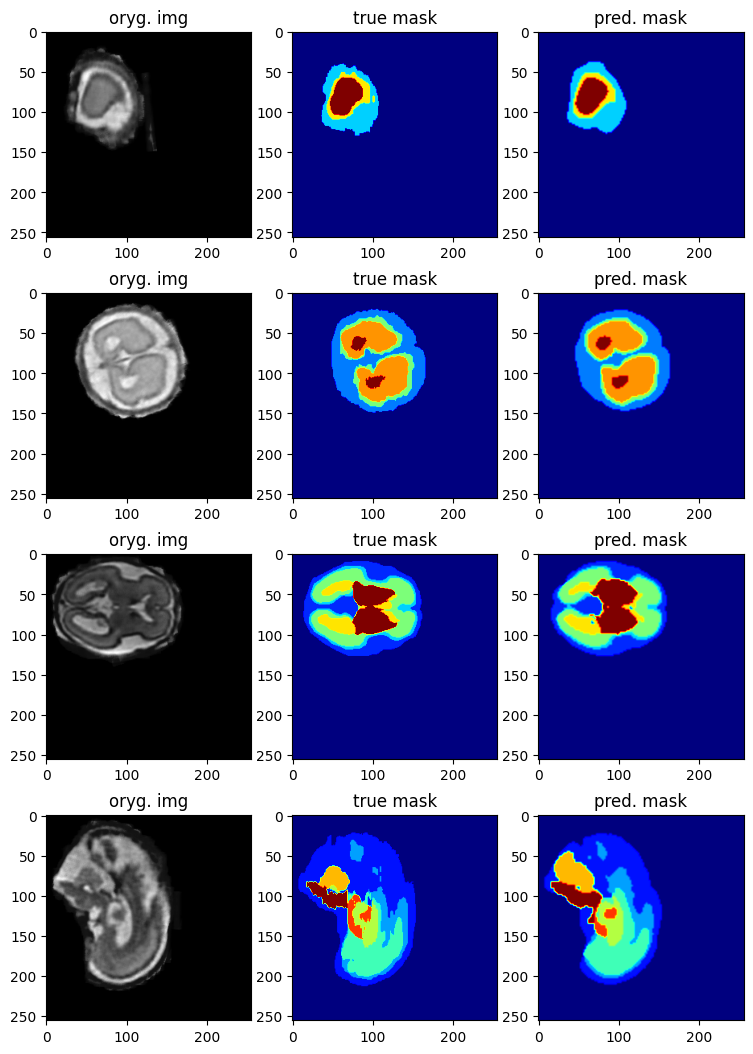

In [7]:
img_idxs = [36, 38, 39, 40]
slice_idxs = [31, 58, 70, 86]
axes = ['X', 'Y', 'Z', 'X']
model_name = "basic_unet_128_local"
visualize_results(configs.DATA_2D_PATH, configs.PREDS_PATH, model_name, img_idxs, slice_idxs, axes)

## Train/validation loss for a given model

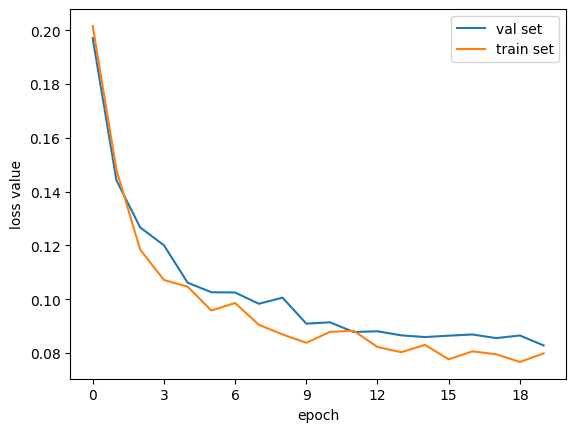

In [3]:
plot_epoch_trainval_loss(configs.BASE_PATH, model_name = 'UNetWithResnet34Encoder_64_celoss', axis = 'Y')